In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tensorflow

In [3]:
!pip install keras

In [4]:
!pip install tensorflow-addons

In [5]:
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers 
import tensorflow_addons as tfa 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
num_classes = 10
input_shape = (32,32,3)
(x_train, y_train), (x_test,y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - x_train shape: {x_train.shape}")
print(f"x_test shape: {x_test.shape} - x_test shape: {x_test.shape}")      

170498071/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3) - x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3) - x_test shape: (10000, 32, 32, 3)


In [7]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
num_heads = 4
projection_dim = 64
transformer_units = [
    projection_dim*2,
    projection_dim
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [8]:
data_augmentation = keras.Sequential(
 [
    layers.Normalization(),
    layers.Resizing(image_size, image_size),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(factor=0.02),
    layers.RandomZoom(
        height_factor = 0.2, width_factor = 0.2)
 ],
 name = "data_augmentation"
)
data_augmentation.layers[0].adapt(x_train)

In [9]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [10]:
class Patches (layers.Layer):
    def __init__(self, patch_size):
        super (Patches, self).__init__()
        self.patch_size = patch_size
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding = "VALID",
        )
        patch_dims = patches. shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per image: 108


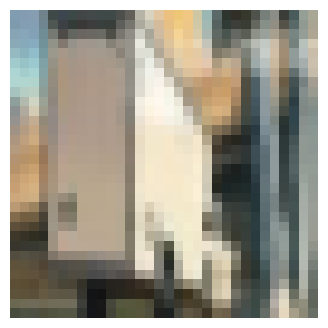

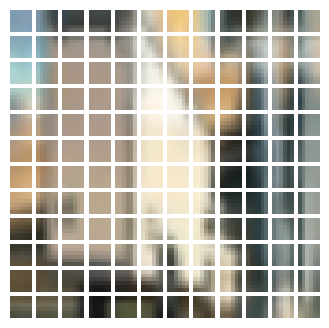

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per image: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize = (4,4))
for i,patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder,self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units = projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )
        
    def call(self, patch):
        positions = tf.range(start=0 , limit = self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [13]:
def create_vit_classifier():
    inputs = layers.Input(shape = input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches (patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    # Create multiple Layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization I
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attension layer
        attention_output = layers.MultiHeadAttention(
            num_heads = num_heads, key_dim = projection_dim, dropout= 0.1
        )(x1, x1)
        # skip connection 1.
        x2 = layers.Add() ([attention_output, encoded_patches])
        # layer normalization 2.
        x3 = layers.LayerNormalization(epsilon= 1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units = transformer_units, dropout_rate= 0.1)
        # Skip connection2.
        encoded_patches = layers.Add()([x3,x2])
    # Create a (batch_ size, projection dim] tensor
    representation = layers.LayerNormalization(epsilon = 1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MIP.
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate=0.5)
    # classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras Model
    model = keras.models.Model(inputs=inputs, outputs=logits)
    return model

In [14]:
import os
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top_5_accuracy")
        ],
    )

    # Ensure the checkpoint directory exists
    checkpoint_dir = "./tmp/"
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint_filepath = os.path.join(checkpoint_dir, "checkpoint")
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback]
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test Top 5 accuracy: {round(top_5_accuracy * 100, 2)}")


In [15]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/40
176/176 [==============================] - 76s 366ms/step - loss: 2.0573 - accuracy: 0.3125 - top_5_accuracy: 0.8113 - val_loss: 1.5116 - val_accuracy: 0.4602 - val_top_5_accuracy: 0.9132
Epoch 2/40
176/176 [==============================] - 65s 372ms/step - loss: 1.5440 - accuracy: 0.4455 - top_5_accuracy: 0.9032 - val_loss: 1.2667 - val_accuracy: 0.5510 - val_top_5_accuracy: 0.9492
Epoch 3/40
176/176 [==============================] - 65s 370ms/step - loss: 1.3772 - accuracy: 0.5079 - top_5_accuracy: 0.9272 - val_loss: 1.1220 - val_accuracy: 0.6014 - val_top_5_accuracy: 0.9600
Epoch 4/40
176/176 [==============================] - 65s 371ms/step - loss: 1.2931 - accuracy: 0.5421 - top_5_accuracy: 0.9394 - val_loss: 1.0658 - val_accuracy: 0.6282 - val_top_5_accuracy: 0.9644
Epoch 5/40
176/176 [==============================] - 66s 374ms/step - loss: 1.2166 - accuracy: 0.5689 - top_5_accuracy: 0.9480 - val_loss: 1.0001 - val_accuracy: 0.6466 - val_top_5_accuracy: 0.9712
Epoch

In [16]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [17]:
def img_predict(images, model):
    if len(images.shape) == 3:
        out = model.predict(images.reshape(-1, *images.shape))
    else:
        out = model.predict(images)
        
    prediction = np.argmax(out, axis = 1)
    img_prediction = [class_names[i] for i in prediction]
    return img_prediction

1/1 [==============================] - 1s 1s/step
['truck']


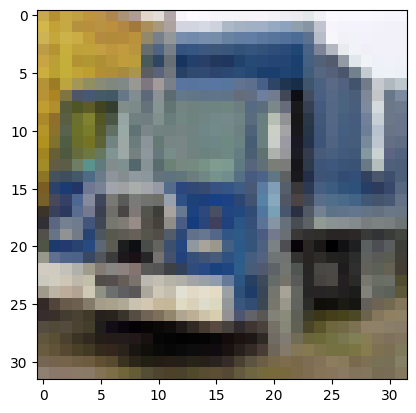

In [18]:
index = 14
plt.imshow(x_test[index])
prediction = img_predict(x_test[index], vit_classifier)
print(prediction)